# 使用Scikit-learn进行像素分类
像素分类是一种将像素分配给多个类别的技术。如果有两个类别（对象和背景），我们称之为二值化。在这个例子中，我们使用[随机森林分类器](https://en.wikipedia.org/wiki/Random_forest)进行像素分类。

另请参阅
* [Scikit-learn随机森林](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)
* [Chris Holden的土地覆盖分类](https://ceholden.github.io/open-geo-tutorial/python/chapter_5_classification.html)

In [1]:
from sklearn.ensemble import RandomForestClassifier

from skimage.io import imread, imshow
import numpy as np
import napari

作为示例图像，使用来自Broad Bioimage Benchmark Collection的图像集[BBBC038v1](https://bbbc.broadinstitute.org/bbbc/BBBC038) [Caicedo et al., Nature Methods, 2019](https://doi.org/10.1038/s41592-019-0612-7)。

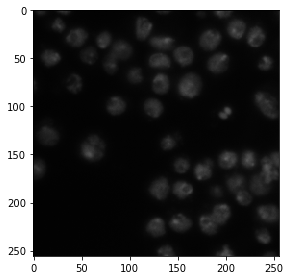

In [2]:
image = imread('../../data/BBBC038/0bf4b1.tif')

imshow(image)

为了演示算法如何工作，我们在图像左侧标注两个小区域，值为1和2，分别表示背景和前景（对象）。

/Users/haase/opt/anaconda3/envs/bio_39/lib/python3.9/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)
/Users/haase/opt/anaconda3/envs/bio_39/lib/python3.9/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


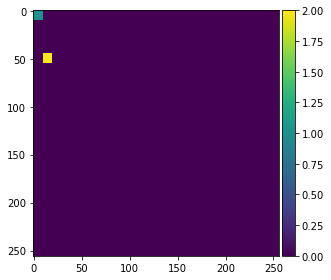

In [3]:
annotation = np.zeros(image.shape)
annotation[0:10,0:10] = 1
annotation[45:55,10:20] = 2

imshow(annotation, vmin=0, vmax=2)

## 生成特征堆栈
像随机森林分类器这样的像素分类器需要多个图像作为输入。我们通常称这些图像为特征堆栈，因为现在每个像素都有多个值（特征）。在以下示例中，我们创建一个包含三个特征的特征堆栈：
* 原始像素值
* 高斯模糊后的像素值
* 高斯模糊图像经过Sobel算子处理后的像素值

因此，我们对图像进行去噪并检测边缘。这三个图像都帮助像素分类器区分正面和负面像素。

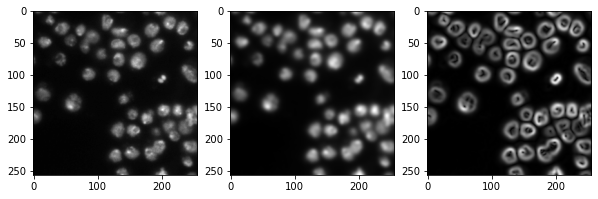

In [4]:
from skimage import filters

def generate_feature_stack(image):
    # determine features
    blurred = filters.gaussian(image, sigma=2)
    edges = filters.sobel(blurred)

    # collect features in a stack
    # The ravel() function turns a nD image into a 1-D image.
    # We need to use it because scikit-learn expects values in a 1-D format here. 
    feature_stack = [
        image.ravel(),
        blurred.ravel(),
        edges.ravel()
    ]
    
    # return stack as numpy-array
    return np.asarray(feature_stack)

feature_stack = generate_feature_stack(image)

# show feature images
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 3, figsize=(10,10))

# reshape(image.shape) is the opposite of ravel() here. We just need it for visualization.
axes[0].imshow(feature_stack[0].reshape(image.shape), cmap=plt.cm.gray)
axes[1].imshow(feature_stack[1].reshape(image.shape), cmap=plt.cm.gray)
axes[2].imshow(feature_stack[2].reshape(image.shape), cmap=plt.cm.gray)

## 格式化数据
我们现在需要格式化输入数据，使其符合scikit-learn的要求。Scikit-learn要求输入数据为形状为(n, m)的数组，标注为(n)。n对应于像素数量，m对应于特征数量。在我们的例子中，m = 3。

In [5]:
def format_data(feature_stack, annotation):
    # reformat the data to match what scikit-learn expects
    # transpose the feature stack
    X = feature_stack.T
    # make the annotation 1-dimensional
    y = annotation.ravel()
    
    # remove all pixels from the feature and annotations which have not been annotated
    mask = y > 0
    X = X[mask]
    y = y[mask]

    return X, y

X, y = format_data(feature_stack, annotation)

print("input shape", X.shape)
print("annotation shape", y.shape)

input shape (200, 3)
annotation shape (200,)


## 训练随机森林分类器
我们现在通过提供特征堆栈X和标注y来训练[随机森林分类器](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)。

In [6]:
classifier = RandomForestClassifier(max_depth=2, random_state=0)
classifier.fit(X, y)

RandomForestClassifier(max_depth=2, random_state=0)

## 预测像素类别
分类器训练完成后，我们可以用它来预测整个图像的像素类别。注意在以下代码中，我们提供了`feature_stack.T`，这比上面命令中的X包含更多像素，因为它还包含了之前未标注的像素。

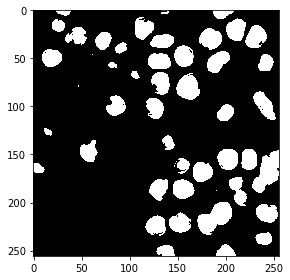

In [7]:
res = classifier.predict(feature_stack.T) - 1 # we subtract 1 to make background = 0
imshow(res.reshape(image.shape))

## 交互式分割
我们还可以使用napari来标注一些区域为负面（标签 = 1）和正面（标签 = 2）。

In [8]:
# start napari
viewer = napari.Viewer()

# add image
viewer.add_image(image)

# add an empty labels layer and keet it in a variable
labels = viewer.add_labels(np.zeros(image.shape).astype(int))

/Users/haase/opt/anaconda3/envs/bio_39/lib/python3.9/site-packages/napari_tools_menu/__init__.py:165: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


**在**标注至少两个区域（标签1和2）后继续。

截取标注的屏幕截图：

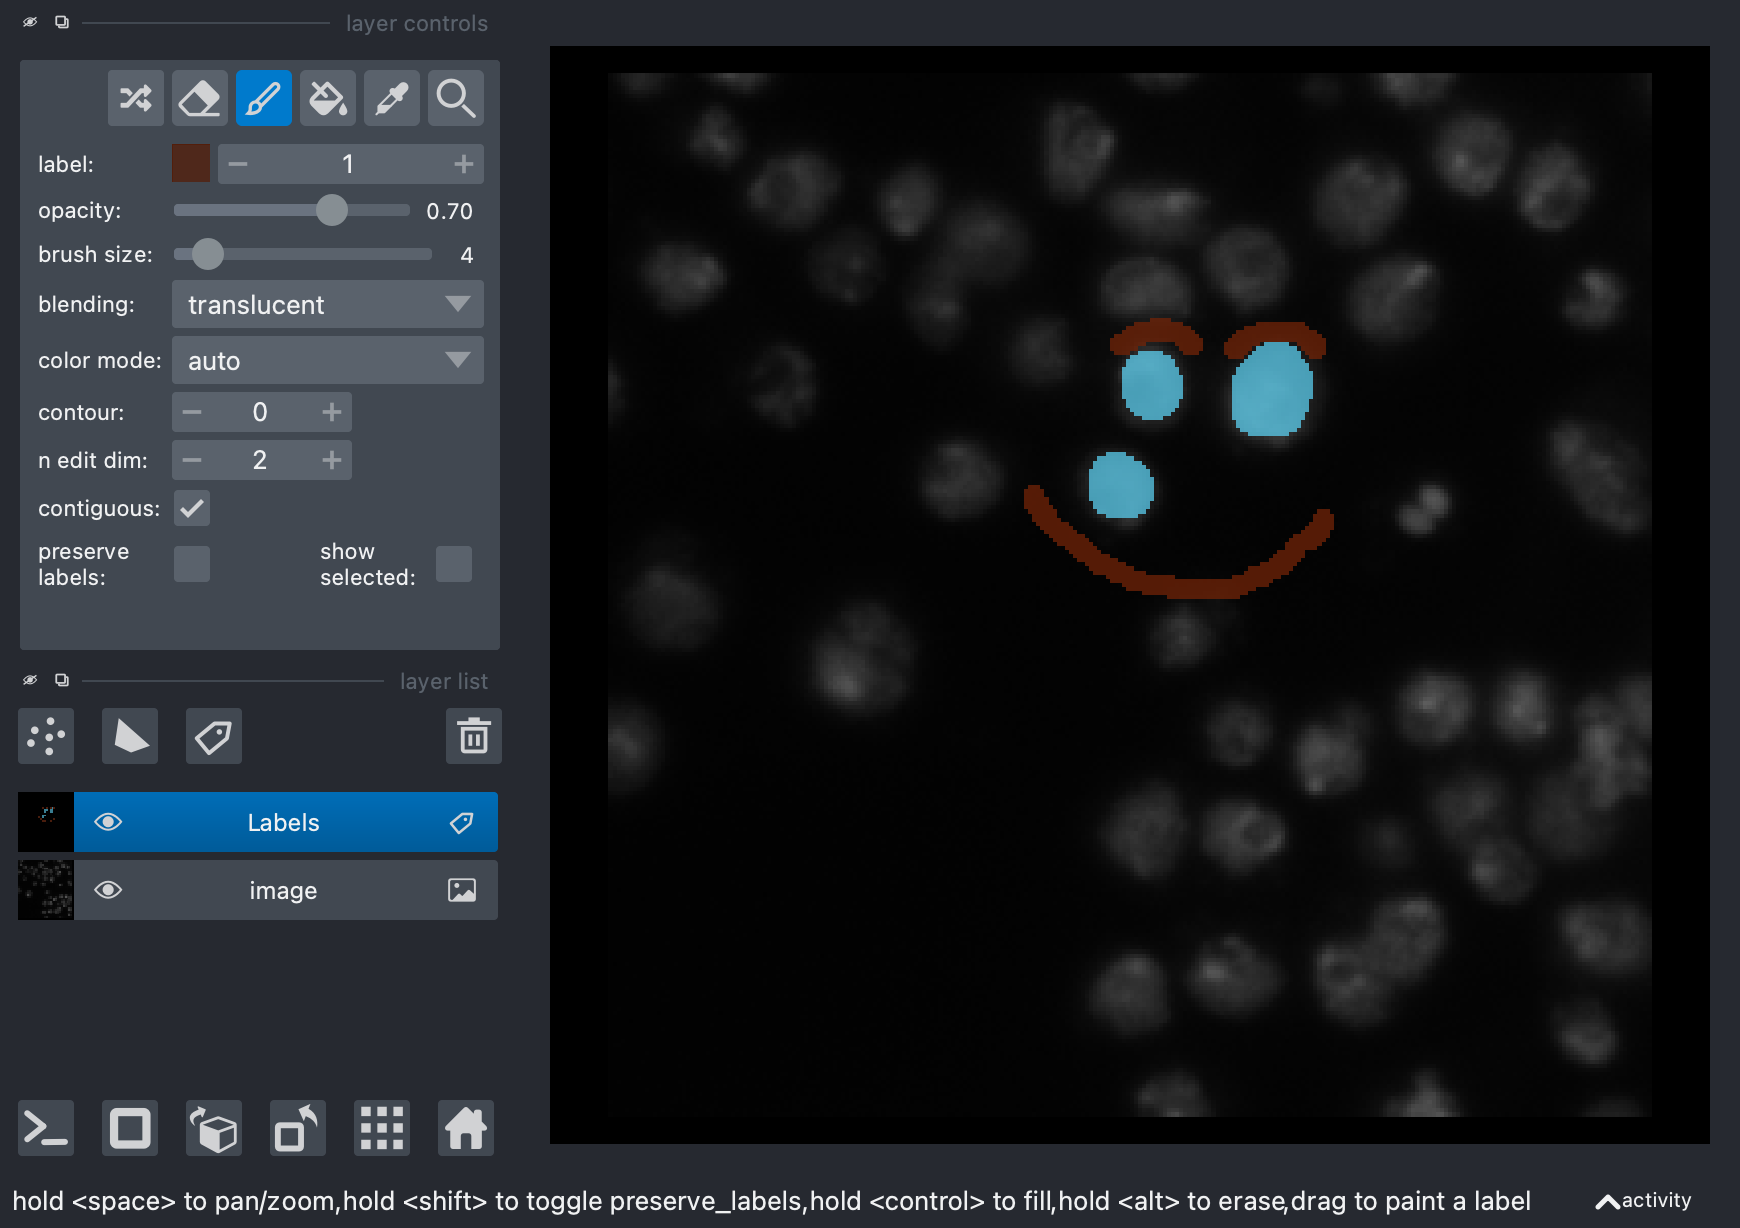

In [9]:
napari.utils.nbscreenshot(viewer)

从napari层中检索标注：

/Users/haase/opt/anaconda3/envs/bio_39/lib/python3.9/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


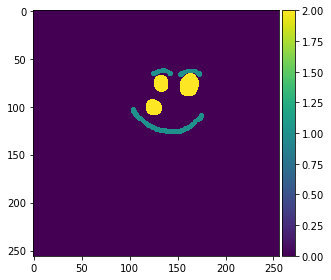

In [10]:
manual_annotations = labels.data

imshow(manual_annotations, vmin=0, vmax=2)

由于我们在上面的例子中使用了函数，我们可以直接用手动标注重复相同的步骤。

/Users/haase/opt/anaconda3/envs/bio_39/lib/python3.9/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


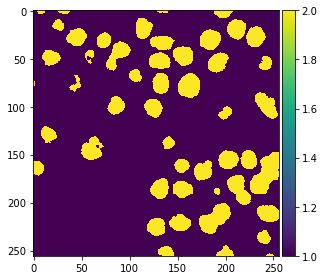

In [11]:
# generate features (that's actually not necessary, 
# as the variable is still there and the image is the same. 
# but we do it for completeness)
feature_stack = generate_feature_stack(image)
X, y = format_data(feature_stack, manual_annotations)

# train classifier
classifier = RandomForestClassifier(max_depth=2, random_state=0)
classifier.fit(X, y)

# process the whole image and show result
result_1d = classifier.predict(feature_stack.T)
result_2d = result_1d.reshape(image.shape)
imshow(result_2d)

我们还将结果添加到napari中。

In [12]:
viewer.add_labels(result_2d)

<Labels layer 'result_2d' at 0x7f816a1faaf0>

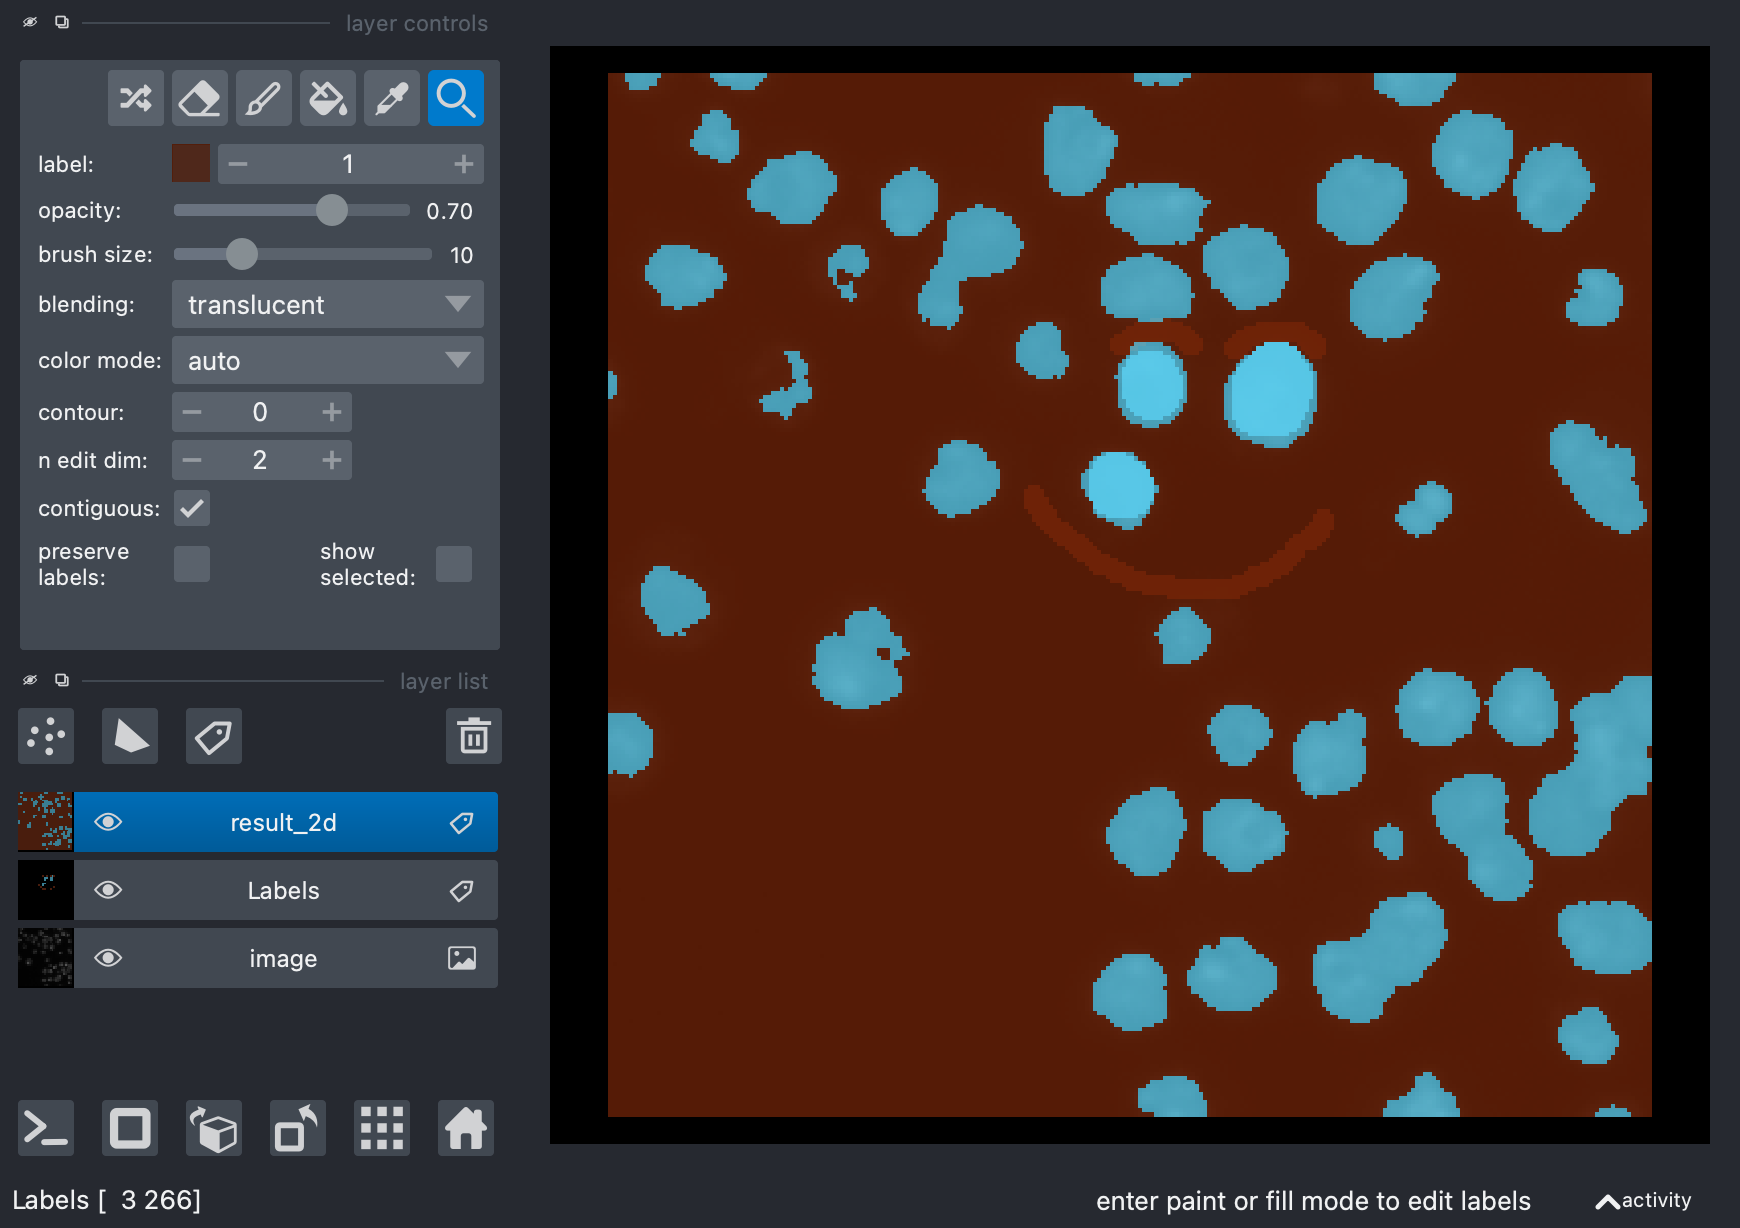

In [13]:
napari.utils.nbscreenshot(viewer)

# 练习
修改代码，使您可以标注三个不同的区域：
* 细胞核
* 背景
* 斑点和背景之间的边缘